In [3]:
import numpy as np
import copy
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm

In [4]:
DEBUG = False
DEBUG_max_H = False
DEBUG_H = False
DEBUG_louvain = False
DEBUG_gamma = False
DEBUG_fit = False
DEBUG_stars = False
example_array = np.array([[0,1,1.5],[1,1,1.5],[2,2,1.5],[2,2,2.5],[10,1,11],[10,2,11.5],[11,0,13]])
louvain_graph_test = np.array([[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
X_broke = np.array([[-2.246, -3.981,  2.676,  2.913,  0.627,  1.389,  0.848,  2.286,
         3.024,  0.647],
       [ 8.911, 10.737,  7.923,  1.001,  6.794,  3.62 ,  9.385,  9.383,
         6.022,  7.122]])
X_triple = np.array([[ 2.21366  ,  0.0649535, -0.901266 , -2.31758  ,  2.16085  ,  0.0246508,
  -0.906181 , -1.79028  , -0.483109 , -0.200504 , -2.11649  ,  0.283352
,   1.561435 ,  2.20756  , -1.48002  ,  0.202273 ,  2.87576  ,  0.0221903,
   2.59456  , -0.162438 ],
 [ 0.0800738,  1.26422  , -0.0276792, -0.248441 , -0.070032 ,  1.5624
  ,-0.0586624, -0.371134 ,  1.28486  ,  0.842022 , -0.131222 ,  0.575172
,  -0.170464 ,  0.704951 , -0.296152 ,  1.1789   ,  0.386286 ,  0.485386
,   0.65093  ,  1.65112  ]])

In [5]:
def H(A,partition,γ):
  m = sum(sum(A))
  res = 0
  for cluster in partition:
    n = len(cluster)
    if n>1:
      for i in range(n):
        for j in range(i+1,n):
          v_i = cluster[i]
          v_j = cluster[j]
          if A[v_i][v_j] > 0:
            k_i,k_j = sum(A[v_i]),sum(A[v_j])

            diff = A[v_i][v_j] - γ*k_i*k_j/m

            res += diff
            if DEBUG_H: print(diff,A[v_i][v_j],v_i,v_j,k_i,k_j,m)
  res = res/m
  return res

def shuffle_N(X, N, seed = 80):
    rng = np.random.default_rng(seed)
    rng.shuffle(X,axis=1)
    return X[:,:N]


In [6]:
class clusterization:
  def __init__(self, K = 3, γ = 1, r = 0.2, distance = "euclidean", weights = "relative", init_partition = "stars", Louvain = False):
    self.K = K
    self.γ = γ
    self.distance = distance
    self.weights = weights
    self.r = r
    self.init_partition = init_partition
    self.Louvain = Louvain

#'--------WEIGHT FUNCTIONS--------'

  def relative_weights(self,neighbors,m):
    A = np.zeros(shape=(m,m))
    if DEBUG_fit: print(neighbors)
    for i in range(m):
      for j in neighbors[i]:
        U = set(neighbors[i])
        V = set(neighbors[j])
        A[i][j] = float(len(U.intersection(V))/len(U.union(V)))
        A[j][i]=A[i][j]
    return A

  def ranking_weights(self,neighbors,m):
    A = np.zeros(shape=(m,m))
    for i in range(m):
      for j in neighbors[i]:
        U = set(neighbors[i])
        V = set(neighbors[j])
        for k in U.intersection(V):
          rang_i = np.argwhere(neighbors[i] == k)
          rang_j = np.argwhere(neighbors[j] == k)
          A[i][j] = max(A[i][j],self.k - 0.5*(rang_i + rang_j))
        A[j][i]=A[i][j]
    return A

#'--------INITIAL PARTITION--------'

  def singletons(self,m):
    partition = list()
    for i in range(m):
      partition.append([i])
    return partition

  def stars(self,A,neighbors,m):
    if DEBUG_stars: print("***STARS***",neighbors)
    partition = list()
    for i in range(m):
      partition.append([i])
      G_i = sum(A[i])
      if G_i > 0:
        for j in neighbors[i]:
          if A[i][j]/G_i >= self.r:
            partition[i].append(int(j))
    if DEBUG_stars: print(partition)

    #removing intersections of G_i
    inst = [[] for _ in range(m)]
    for i,arr in enumerate(partition):
      for j in arr:
        inst[j].append(i)
    if DEBUG_stars: print("instances", inst)
    for i,arr in enumerate(inst):
      w_max = sum(A[i])/np.count_nonzero(A[i]) #relative weight of i in G_i
      G_i_max = i
      w_temp = 0
      for j in arr:
        if i != j:
          w_temp = A[j][i] #A[j][i]/1
        if w_max < w_temp:
          w_max = w_temp
          G_i_max = j
      for j in inst[i]:
        if j!=G_i_max:
          partition[j].remove(i)
      if DEBUG_stars: print("removed",i,"from other stars",partition)

    return partition

#'--------MAXIMIZING H--------'

  def maximize_H(self,A,partition = []):

      if (partition == []):
        partition = self.singletons(A.shape[0])
      m = sum(sum(A))
      H_temp = H(A,partition,self.γ)
      H_max = H_temp
      is_maximized = False

      i = 0
      n = len(partition) #TO DO FIND MORE NUMPYISH WAY TO DO THIS
      while i<n:
          if not partition[i]:
              partition.remove(partition[i])
              n-=1
          else:
              partition[i] = sorted(partition[i])
              i+=1
      if DEBUG_max_H: print("INIT PARTITION",partition)
      max_partition = copy.deepcopy(partition)

      while not is_maximized:
        if DEBUG_max_H: print("+++NEXT STEP+++")
        is_maximized = True

        for i in range(len(partition)):
          if DEBUG_max_H: print("Considering adding a vertex to cluster №" + str(i))
          for j in range(len(partition)):
            if j == i:
              if DEBUG_max_H: print("i = j = " + str(i))
              continue

            if DEBUG_max_H: print("Let's take a vertex from cluster №" + str(j))
            for v in partition[j]:
              temp_partition = copy.deepcopy(partition)
              temp_partition[i].append(v)
              if len(temp_partition[j]) > 1:
                temp_partition[j].remove(v)
              else: #temp_partition[j] = [v]
                temp_partition.remove([v])
              if DEBUG_max_H: print("adding vertex ",str(v)," to cluster №",str(i)," from cluster №",str(j));print(temp_partition)
              if H(A,temp_partition,self.γ) > H_temp:
                if DEBUG_max_H: print("---the value",H(A,temp_partition,self.γ)," is bigger!---")
                is_maximized = False
                max_partition = temp_partition
                H_temp = H(A,max_partition,self.γ)
        partition = copy.deepcopy(max_partition)
        H_max = H_temp
        if DEBUG_max_H: print("STEP ENDED WITH H_MAX = ",H_max,partition)
      i = 0
      n = len(max_partition) #TO DO FIND MORE NUMPYISH WAY TO DO THIS
      while i<n:
          if not max_partition[i]:
              max_partition.remove(max_partition[i])
              n-=1
          else:
              max_partition[i] = sorted(max_partition[i])
              i+=1
      max_partition = sorted(max_partition)
      return max_partition, H_max

#'--------Louvain--------'

  def louvain(self,A,partition,H_max):
    if DEBUG_louvain: print("Louvain procedure",partition,H_max)
    Partitions = list([partition]); Graphs = list([A])
    while True:
        A = Graphs[-1]; partition = Partitions[-1]; m = np.size(A,axis=0) # previous graph
        n = len(partition) # amount of clusters in an old graph = amount of vertices in a new graph
        A_new = np.zeros(shape=(n,n))
        Graphs.append(A_new) #new graph

        for i in range(m):
          for j in range(m):
            if (A[i][j]):
              idx_i = [k for k,l in enumerate(partition) if i in l][0] # index of cluster with vertex i
              idx_j = [k for k,l in enumerate(partition) if j in l][0] # >--------------------------< j
              A_new[idx_i][idx_j] += A[i][j]

        if DEBUG_louvain: print("new matrix",A_new)

        partition_new = self.singletons(n)
        partition_new, H_temp = self.maximize_H(A_new,partition_new)

        if DEBUG_louvain: print("New partition is ",partition_new, "H_max =", str(H(A_new,partition_new,self.γ)))

        if H(A_new,partition_new,self.γ) == 0:
          break
        else:
          Partitions.append(partition_new)

    for i in range(len(Partitions)-1,0,-1):
      new_list = list()
      for j in range(len(Partitions[i])):
        if not Partitions[i][j]:
          continue

        k = Partitions[i][j][0]
        Partitions[i][j].remove(k)
        list_to_concat = Partitions[i][j]
        list_to_concat = np.sort(list_to_concat)[::-1]
        for l in list_to_concat:
          if DEBUG_louvain: print(i, k, l, Partitions[i-1],list_to_concat)
          Partitions[i-1][k] += Partitions[i-1][l]

        new_list.append(Partitions[i-1][k])
      Partitions[i-1] = new_list
      if DEBUG_louvain: print("transformed partition",new_list)

    partition = Partitions[0]
    H_max = H(Graphs[0],partition,self.γ)
    if DEBUG: print("Final Louvain partition is ",partition)
    return partition, H_max

#'--------FIT--------'

  def fit(self, X):
      #X = X.transpose() #it is more natural to work with a transposed features-cells matrix
      m = np.size(X,axis=0)
      n = np.size(X,axis=1)
      if m < n: #assuming there should be more cells than features
        X = X.transpose()
        m, n = n, m
      self.X = X


      #findind k-neigbors
      neighbors = np.empty(shape=(m,self.K),dtype=int)
      if DEBUG: print("Finding neighbors")
      dist_f = lambda a, b : np.sqrt(np.sum((a-b)**2,axis=1))
      match self.distance:
        case "euclidean":
          dist_f = lambda a, b : np.sqrt(np.sum((a-b)**2,axis=1))
        case "manhattan":
          dist_f = lambda a, b : np.sum(abs(a-b),axis=1)
        case "chebyshev":
          dist_f = lambda a, b : np.max(abs(a-b),axis=1)
      for i in range(m):
        cell = X[i]
        dist = dist_f(X,cell)
        neighbors[i] = np.argsort(dist)[1:(self.K+1)]
      #assigning weights
      if DEBUG: print("Evaluating weights")
      match self.weights:
        case "relative":
          A = self.relative_weights(neighbors,m)
        case "ranking":
          A = self.ranking_weights(neighbors,m)

      #making an initial partition
      if DEBUG: print("making an initial partition")
      match self.init_partition:
        case "singletons":
          partition = self.singletons(m)
        case "stars":
          partition = self.stars(A,neighbors,m)

      #maximizing H
      if DEBUG: print("maximizing H")
      partition, H_max = self.maximize_H(A,partition)
      if DEBUG: print("partition is ",partition,"H_max =",str(H_max))

      if self.Louvain:
        partition, H_max = self.louvain(A,partition,H_max)
      partition = [sorted(prt) for prt in sorted(partition)]
      self.partition = partition; self.H_max = H_max
      return partition, H_max, A

  def plot2d(self):
      X_concat = np.concatenate(((self.X).transpose(), [np.zeros(np.size(self.X,axis=0))]))#classes
      for i,part in enumerate(self.partition):
          for j in part:
              X_concat[2][j] = i


      colors_clusters = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray','lime','sienna','peru','crimson','indigo','olive','ivory','cyan','hotpink','lawngreen','tan','slategray']
      plt.figure(1)
      plt.scatter(X_concat[0],X_concat[1])
      X_concat = X_concat.transpose()
      plt.figure(2)
      for i,point in enumerate(X_concat):
          plt.scatter(point[0],point[1], c = colors_clusters[int(point[2])])
          #plt.annotate(str(i), (point[0], point[1]))


  def plot3d(self):
    X_concat = np.concatenate(((self.X).transpose(), [np.zeros(np.size(self.X,axis=0))]))#classes
    for i,part in enumerate(self.partition):
        for j in part:
            X_concat[3][j] = i


    colors_clusters = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w','lime','sienna','peru','crimson','indigo']
    fig = plt.figure(1)
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X_concat[0],X_concat[1],X_concat[2])
    X_concat = X_concat.transpose()
    fig2 = plt.figure(2)
    ax2 = fig2.add_subplot(projection='3d')
    for point in X_concat:
        ax2.scatter(point[0],point[1], point[2], c = colors_clusters[int(point[3])])

In [7]:
def find_gamma_bound(X, k, γ1, γ2, r, eps, distance = "euclidean",init_partition="stars", Louvain = False):
  if DEBUG_gamma: print("Called with [",γ1," ",γ2,"]")
  if γ1 > γ2:
    γ1,γ2 = γ2,γ1
  c1 = clusterization(k, γ1, r,distance=distance,init_partition=init_partition, Louvain=Louvain)
  c2 = clusterization(k, γ2, r,distance=distance,init_partition=init_partition, Louvain=Louvain)
  if (c1.fit(X)[0]==c2.fit(X)[0]):
    if DEBUG_gamma: print("Identical partitions")
    return -2
  γ_mean = (γ1+γ2) / 2
  while (abs(γ1-γ2) > eps and c1.fit(X)[0] != c2.fit(X)[0]):
    if DEBUG_gamma: print("considering [",γ1," ",γ2,"]")
    γ_mean = (γ1+γ2) / 2
    c3 = clusterization(k, γ_mean, r,distance=distance,init_partition=init_partition,Louvain=Louvain)
    if (c3.fit(X)[0]==c1.fit(X)[0]):
      if DEBUG_gamma: print("γ1 and γ_mean tield the same")
      c1 = copy.copy(c3)
      γ1 = γ_mean
    elif (c3.fit(X)[0]==c2.fit(X)[0]):
      if DEBUG_gamma: print("γ2 and γ_mean tield the same")
      c2 = copy.copy(c3)
      γ2 = γ_mean
    else:
      if DEBUG_gamma: print("There is another partition inbetween those values")
      return -1
  return round(γ_mean,3)

def find_all_gammas(X, k, γ1, γ2, r, eps, distance="euclidean",init_partition="stars", Louvain=False, borders = []):
  γ_mean = find_gamma_bound(X,k,γ1,γ2,r,eps,distance,init_partition, Louvain)
  if abs(γ1-γ2) >= eps and (γ_mean == -1):
    a = find_all_gammas(X, k, γ1       , (γ1+γ2)/2, r, eps, distance, init_partition, Louvain, borders)
    b = find_all_gammas(X, k, (γ1+γ2)/2, γ2       , r, eps, distance, init_partition, Louvain, borders)
  if γ_mean >= 0:
    if DEBUG_gamma: print("found gamma γ_mean = ",γ_mean)
    borders.append(γ_mean)
  return borders

def find_linear(x1,y1,x2,y2):
  return (y2*x1-y1*x2)/(x1-x2), (y1-y2)/(x1-x2)

**Code Testing**

In [11]:
find_all_gammas(X_broke, 3, 0, 10, 0.2, 1e-3, distance="euclidean",borders=[])

[0.001, 1.0, 1.28, 1.524, 1.778, 1.867, 2.222, 2.857, 3.333, 7.901]

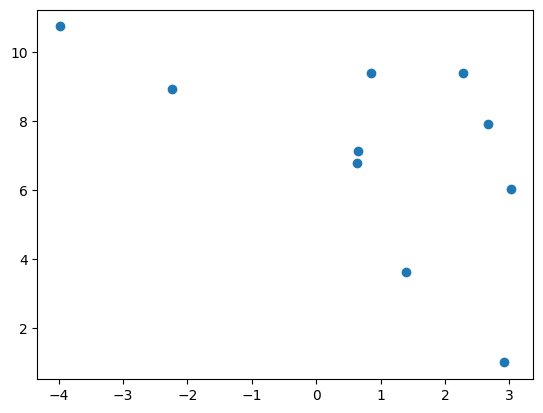

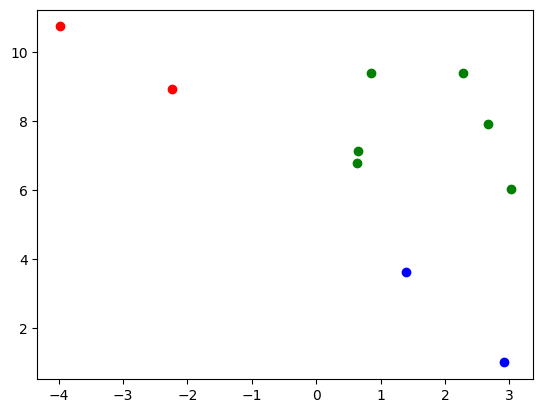

In [ ]:
c = clusterization(3,0.000001,distance="euclidean")
prt,h,a=c.fit(X_broke)
c.plot2d()

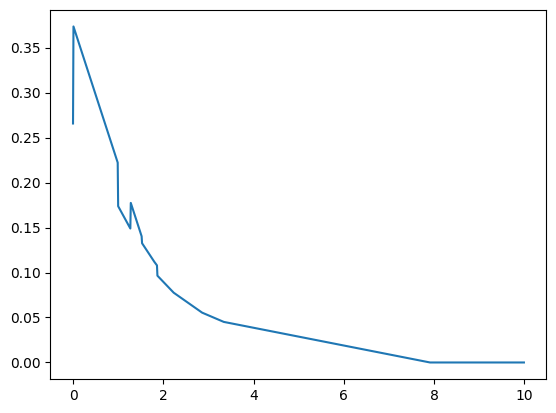

In [ ]:
x = np.arange(0,10,0.01)
y = np.array([clusterization(3,i,distance="euclidean").fit(X_broke)[1] for i in x])
plt.plot(x,y)

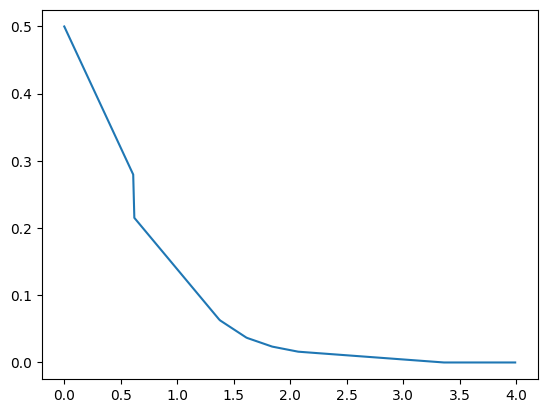

In [ ]:
x = np.arange(0,4,0.01)
y = np.array([clusterization(4,i,distance="chebyshev",init_partition="singletons").fit(example_array)[1] for i in x])
plt.plot(x,y)

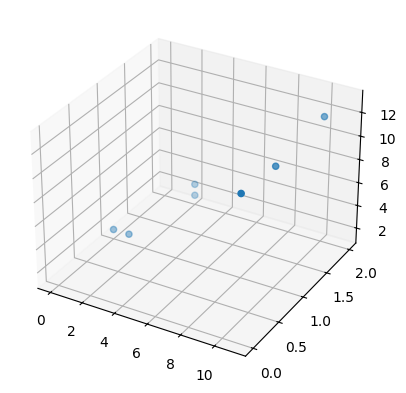

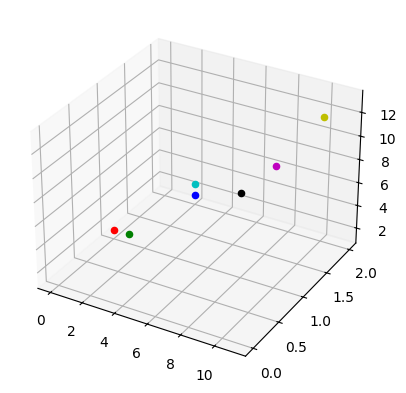

In [ ]:
c = clusterization(4,4,distance="chebyshev",init_partition="singletons")
prt,h,a=c.fit(example_array)
c.plot3d()

In [ ]:
find_all_gammas(example_array, 4, 0, 5, 0.2, 1e-3, dist="chebyshev",init_partition="singletons",borders=[])

[0.612, 1.375, 1.614, 1.84, 2.071, 3.353]

In [ ]:
clusterization(4,2.04).fit(example_array)

([[np.int64(0), np.int64(1), np.int64(5), np.int64(6)],
  [np.int64(2)],
  [np.int64(3)],
  [np.int64(4)]],
 np.float64(0.008689579561734441),
 array([[0.        , 0.6       , 0.6       , 0.6       , 0.33333333,
         0.        , 0.        ],
        [0.6       , 0.        , 0.6       , 0.6       , 0.33333333,
         0.        , 0.        ],
        [0.6       , 0.6       , 0.        , 0.6       , 0.14285714,
         0.33333333, 0.33333333],
        [0.6       , 0.6       , 0.6       , 0.        , 0.14285714,
         0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.14285714, 0.14285714, 0.        ,
         0.6       , 0.6       ],
        [0.        , 0.        , 0.33333333, 0.33333333, 0.6       ,
         0.        , 0.6       ],
        [0.        , 0.        , 0.33333333, 0.33333333, 0.6       ,
         0.6       , 0.        ]]))

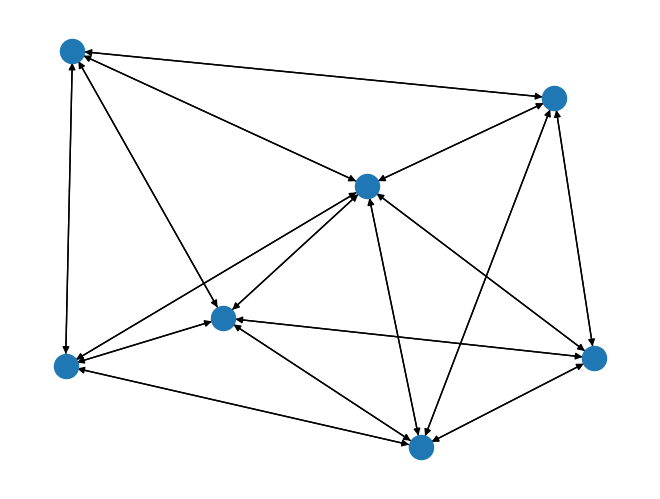

In [ ]:
c = clusterization(4,2,distance="manhattan")
A = c.fit(example_array)[2]
G = nx.from_numpy_array(A, create_using=nx.DiGraph)
layout = nx.spring_layout(G)
nx.draw(G, layout)
#nx.draw_networkx_edge_labels(G, pos=layout)
plt.show()

Louvain procedure [[0, 4, 12, 13, 16, 18], [1, 5, 8, 19], [2, 6, 14], [3, 7, 10], [9, 11, 15, 17]] 0.3563079845131128
new matrix [[8.  0.  0.  0.  0. ]
 [0.  2.6 0.  0.  0.8]
 [0.  0.  3.  0.8 0. ]
 [0.  0.  0.8 3.  0. ]
 [0.  0.8 0.  0.  3.6]]
New partition is  [[0], [1, 4], [2, 3]] H_max = 0.014683322375630064
new matrix [[8.  0.  0. ]
 [0.  7.8 0. ]
 [0.  0.  7.6]]
New partition is  [[0], [1], [2]] H_max = 0.0
1 1 4 [[0, 4, 12, 13, 16, 18], [1, 5, 8, 19], [2, 6, 14], [3, 7, 10], [9, 11, 15, 17]] [4]
1 2 3 [[0, 4, 12, 13, 16, 18], [1, 5, 8, 19, 9, 11, 15, 17], [2, 6, 14], [3, 7, 10], [9, 11, 15, 17]] [3]
transformed partition [[0, 4, 12, 13, 16, 18], [1, 5, 8, 19, 9, 11, 15, 17], [2, 6, 14, 3, 7, 10]]


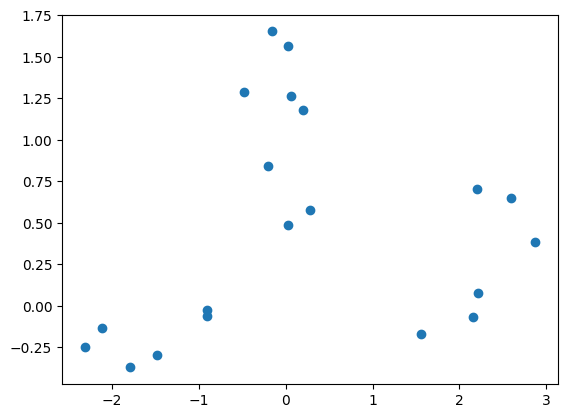

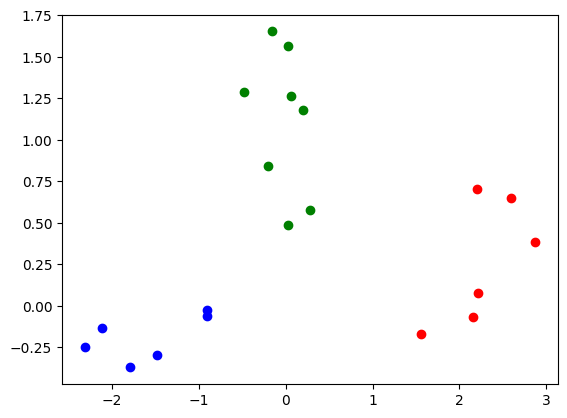

In [ ]:
c = clusterization(3,1,Louvain=True)
c.fit(X_triple)
c.plot2d()

In [ ]:
find_all_gammas(X_triple,3,10,40,0.2,1e-3,Louvain=True)

[10.001, 10.834, 12.929, 12.931, 13.0, 13.002, 13.004, 32.499]

In [ ]:
bounds = np.array([1.251, 1.296, 1.912, 3.9, 4.255, 4.875, 5.318, 5.417, 6.0, 6.5, 6.5, 6.5, 6.964, 6.964, 6.964, 8.125, 8.125, 8.906, 8.907, 8.907, 8.907, 8.911, 8.911, 8.911, 8.911, 8.911, 8.911, 8.912, 8.912, 8.913, 8.913, 8.913, 8.978, 8.978, 8.981, 8.981, 8.981, 8.981, 8.984, 8.984, 8.984, 8.984, 8.984, 8.984, 8.985, 8.986, 8.986, 8.99, 8.99, 9.035, 9.035, 9.035, 9.035, 9.272, 9.272, 9.273, 9.273, 9.273, 9.273, 9.277, 9.277, 9.277, 9.277, 9.277, 9.278, 9.279, 9.279, 9.295, 9.295, 9.295, 9.296, 9.296, 9.296, 9.297, 9.297, 9.297, 9.297, 9.297, 9.297, 9.301, 9.301, 9.302, 9.302, 9.302, 9.302, 9.303, 9.303, 9.303, 9.303, 9.303, 9.37, 9.37, 9.37, 9.37, 9.37, 9.371, 9.375, 9.375, 9.375, 9.375, 9.375, 9.376, 9.376, 9.376, 9.393, 9.393, 9.393, 9.393, 9.393, 9.393, 9.394, 9.394, 9.395, 9.399, 9.399, 9.399, 9.399, 9.399, 9.4, 9.401, 9.401, 9.401, 9.401, 9.401, 9.687, 9.688, 9.98, 9.981, 9.999, 9.999,10.0,10.0])
np.unique(bounds)

array([ 1.251,  1.296,  1.912,  3.9  ,  4.255,  4.875,  5.318,  5.417,
        6.   ,  6.5  ,  6.964,  8.125,  8.906,  8.907,  8.911,  8.912,
        8.913,  8.978,  8.981,  8.984,  8.985,  8.986,  8.99 ,  9.035,
        9.272,  9.273,  9.277,  9.278,  9.279,  9.295,  9.296,  9.297,
        9.301,  9.302,  9.303,  9.37 ,  9.371,  9.375,  9.376,  9.393,
        9.394,  9.395,  9.399,  9.4  ,  9.401,  9.687,  9.688,  9.98 ,
        9.981,  9.999, 10.   ])

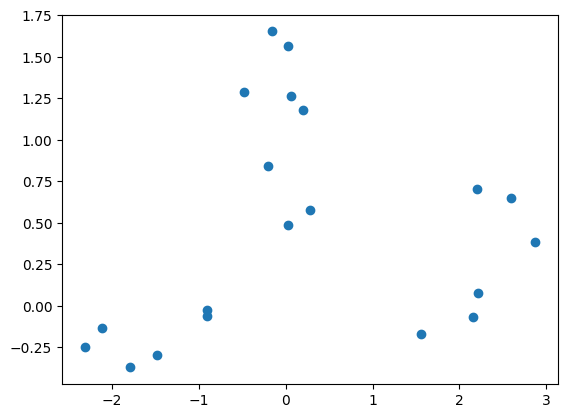

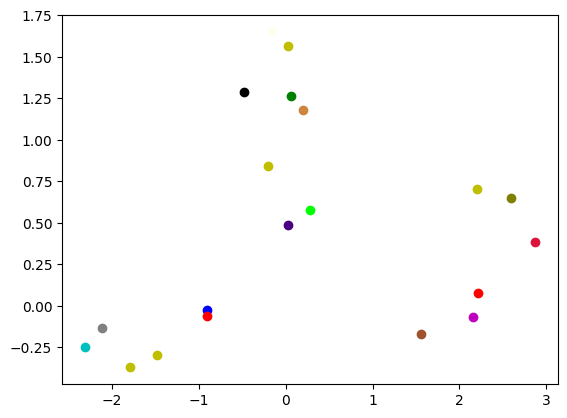

In [ ]:
c=clusterization(3,40,Louvain=True)
c.fit(X_triple)
c.plot2d()